# Machine learning capstone project - fx spot prediction

The goal is to create features that can help predict the bid price, using a lookback period of a few minutes.

Try to include the bid offer spread - from the benchmark model it seems volume is not an important feature so it is not a problem that i dont have this data point.

I took inspiration from : https://www.kaggle.com/kimy07/eurusd-15-minute-interval-price-prediction/notebook

Introduction
This notebook trains a LSTM model that predicts the bid price of EURUSD 15 minutes in the future by looking at last five hours of data. While there is no requirement for the input to be contiguous, it's been empirically observed that having the contiguous input does improve the accuracy of the model. I suspect that having day of the week and hour of the day as the features mitigates some of the seasonality and contiguousness problems.

Disclaimer: This exercise has been carried out using a small sample data which only contains 14880 samples (2015-12-29 00:00:00 to 2016-05-31 23:45:00) and lacks ASK prices. Which restricts the ability for the model to approach a better accuracy.

I will use 1 year of data, from 1Jan16 to 1Jan17, also in 15 minute intervals, but with tick data features.

Improvements

To tune the model further, I would recommend having at least 5 years worth of data, have ASK price (so that you can compute the spread), and increasing the epoch to 3000.
Adding more cross-axial features. Such as spread.
If you are looking into classification approach (PASS, BUY, SELL), consider adding some technical indicators that is more sensitive to more recent data.
Consider adding non-numerical data, e.g. news, Tweets. The catch is that you have to get the data under one minute for trading, otherwise the news will be reflected before you even make a trade. If anybody knows how to get the news streamed really fast, please let me know.

Credits : Dave Y. Kim, Mahmoud Elsaftawy,

To run on EC2:
- Enter the repo directory: cd aind2-cnn
- Activate the new environment: source activate aind2
- Start Jupyter: jupyter notebook --ip=0.0.0.0 --no-browser
- Find this line in output and copy url to browser: 
- Copy/paste this URL into your browser when you connect for the first time to login with a token: http://0.0.0.0:8888/?token=3156e...
- change the 0.0.0.0 with EC2 IP.
- you should see the checked out repository

In [1]:
import pandas as pd, numpy as np
import pypyodbc
import io, datetime, os
import matplotlib.colors as colors, matplotlib.cm as cm, pylab, matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from subprocess import check_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import pypyodbc
display(HTML("""<script>
  
    $('.ctb_hideshow').css({'display': 'block'});
    
    </script>
 """))

In [3]:
initval = True

In [4]:
#kaggle dates: 2015-12-29 00:00:00 to 2016-05-31 23:45:00
min_date = "29Dec15"
max_date = "31May16"

if initval:
    rerunSQL = False
    log = False
    useKaggle = False
    runLSTMBinary = False
    simname = "500_epochs"
    sim_desc = """
    kaggle params but with 500 epochs to account for more features
    """

# Load data

In [10]:
if log:
    #log = {"simname": ["mine_initial", simname], "sim_desc": ["kaggle params", sim_desc]}
    #df_log = pd.DataFrame(log)
    if os.path.isfile("sim_log.xlsx"):
        df_log = pd.read_excel("sim_log.xlsx")
        df_log.loc[len(df_log)]= [simname, sim_desc] 
        df_log.to_excel("sim_log.xlsx")

In [11]:
df_log = pd.read_excel("sim_log.xlsx")
display(pd.read_excel("log_results.xlsx").T)
#display(df_log)

,0,1,2,3,4
simname,500_epochs,500_epoch_lookback_40,linear regression,linear regression,500_epochs_40_lookback_pca_unshuffled
sim_desc,\nkaggle params but with 500 epochs to account...,"500 iterations, lookback 40",1 row lookback,1 row lookback,added directional errors checking and pca as f...
MSE,1.59188e-07,1.97246e-07,6.79626e-07,6.55241e-08,4.82937e-07
MAE,0.000285781,0.000340846,0.000536307,0.000202905,0.000594482
count,102,102,103,103,102
mean,-9.29131e-07,-3.83515e-05,-5.08408e-05,-2.90581e-05,0.000506372
std,0.000400953,0.00044465,0.000826849,0.000255566,0.000478296
min,-0.00135148,-0.00127888,-0.00317997,-0.000772953,-0.00072515
25%,-0.000158489,-0.000304043,-0.000402606,-0.000200629,0.000192821
50%,6.07371e-05,-5.84126e-06,-3.07747e-05,-2.43187e-05,0.000540495


In [12]:
# create 15 minute data - this fills the 15 minutes table
if rerunSQL:
    str_query = open("get_data.sql", "r").read() # returns prepared data
    str_query = str_query.replace("/*", "").replace("*/", "")

    df = getQueryDataframe(str_query, [min_date, max_date])

In [13]:
# dates only have an effect if a subset of dates is needed.
if rerunSQL:
    str_query = open("get_data_1y.sql", "r").read() # returns prepared data
    str_query = str_query.replace("/*", "").replace("*/", "")
    #print(str_query)
    df = getQueryDataframe(str_query, [min_date, max_date])
    df.head()

In [14]:
if rerunSQL:
    df.set_index('datestamp', inplace=True)
    df.index = pd.to_datetime(df.index) # else fill betweeen doesnt work
    print("min date", min(df.index))
    print("max date", max(df.index))

In [15]:
if rerunSQL:
    df.to_csv("data/eurusd_features.csv")

# Create features

In [5]:
df = pd.read_csv("data/eurusd_features.csv")
df.set_index('datestamp', inplace=True)
df.index = pd.to_datetime(df.index) # else fill betweeen doesnt work

In [6]:
if useKaggle:
    # load kaggle reference dataset for comparison
    df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_sample.csv')
    #df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')

    # Rename bid OHLC columns
    df_kaggle.rename(columns={'Time' : 'date', 'Open' : 'open_bid', 'Close' : 'close_bid', 
                       'High' : 'high_bid', 'Low' : 'low_bid', 'Volume' : 'volume'}, inplace=True)
    df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], infer_datetime_format=True)
    df_kaggle.set_index('date', inplace=True)
    df_kaggle = df_kaggle.astype(float)

    simname = "bm_kaggle"

    df = df_kaggle
    print("min date", min(df.index))
    print("max date", max(df.index))

In [7]:
# to include seasonality as a feature
if simname == "bm_kaggle":
    df['hour'] = df.index.hour
    df['day']  = df.index.weekday
    df['week'] = df.index.week
    df['month'] = df.index.month
    df['momentum']  = df['volume'] * (df['open_bid'] - df['close_bid'])
    
df['avg_price'] = (df['low_bid'] + df['high_bid'])/2
df['range']     = df['high_bid'] - df['low_bid']
df['ohlc_price'] = (df['low_bid'] + df['high_bid'] + df['open_bid'] + df['close_bid'])/4
df['oc_diff']    = df['open_bid'] - df['close_bid']
df['period_return'] = df.close_bid / df.open_bid

# Explore dataset - show some graphs

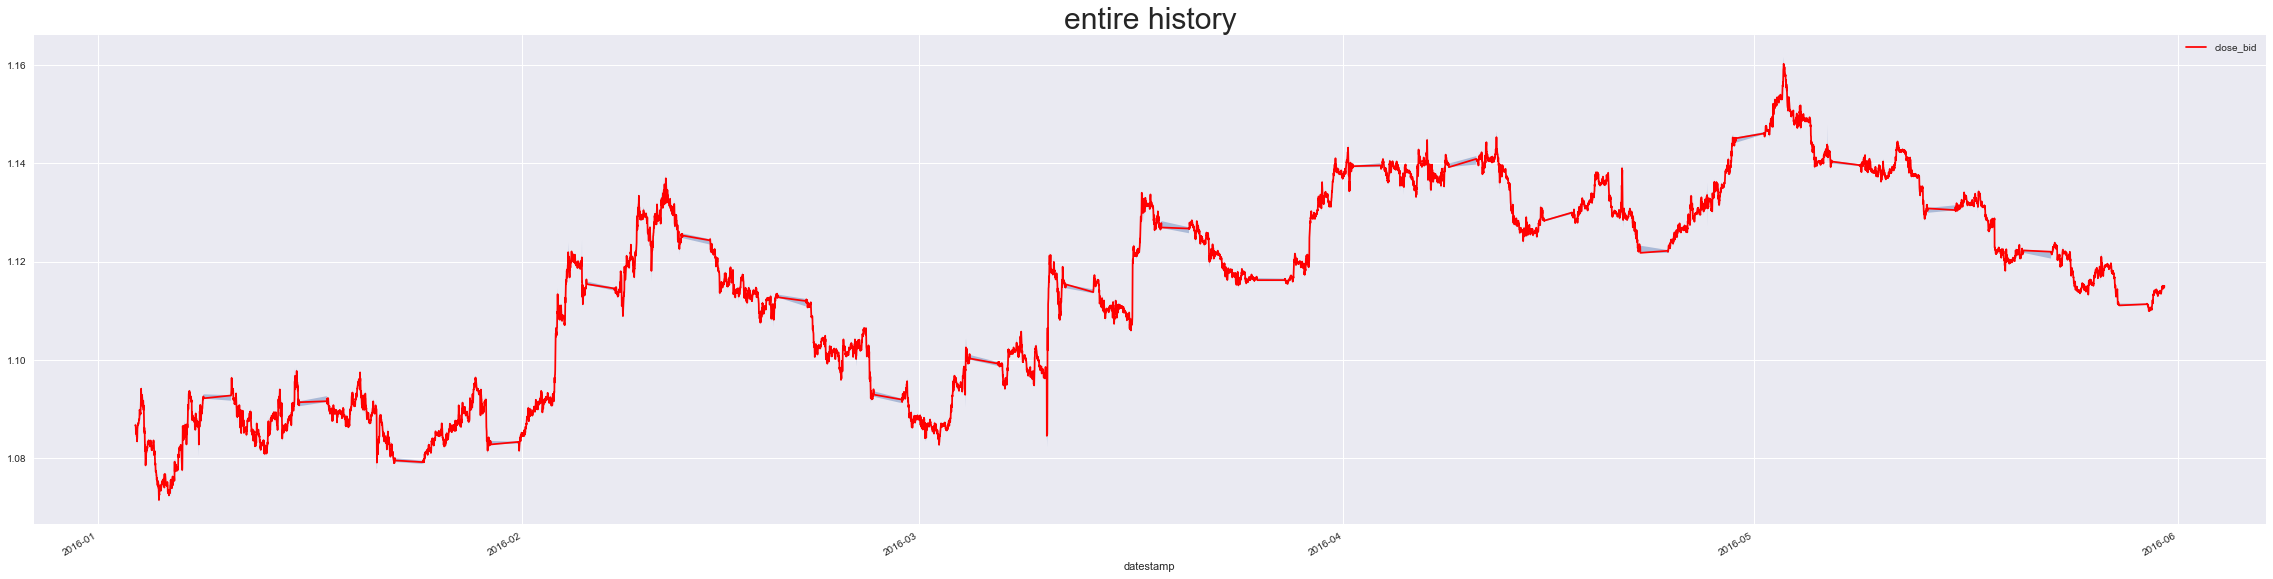

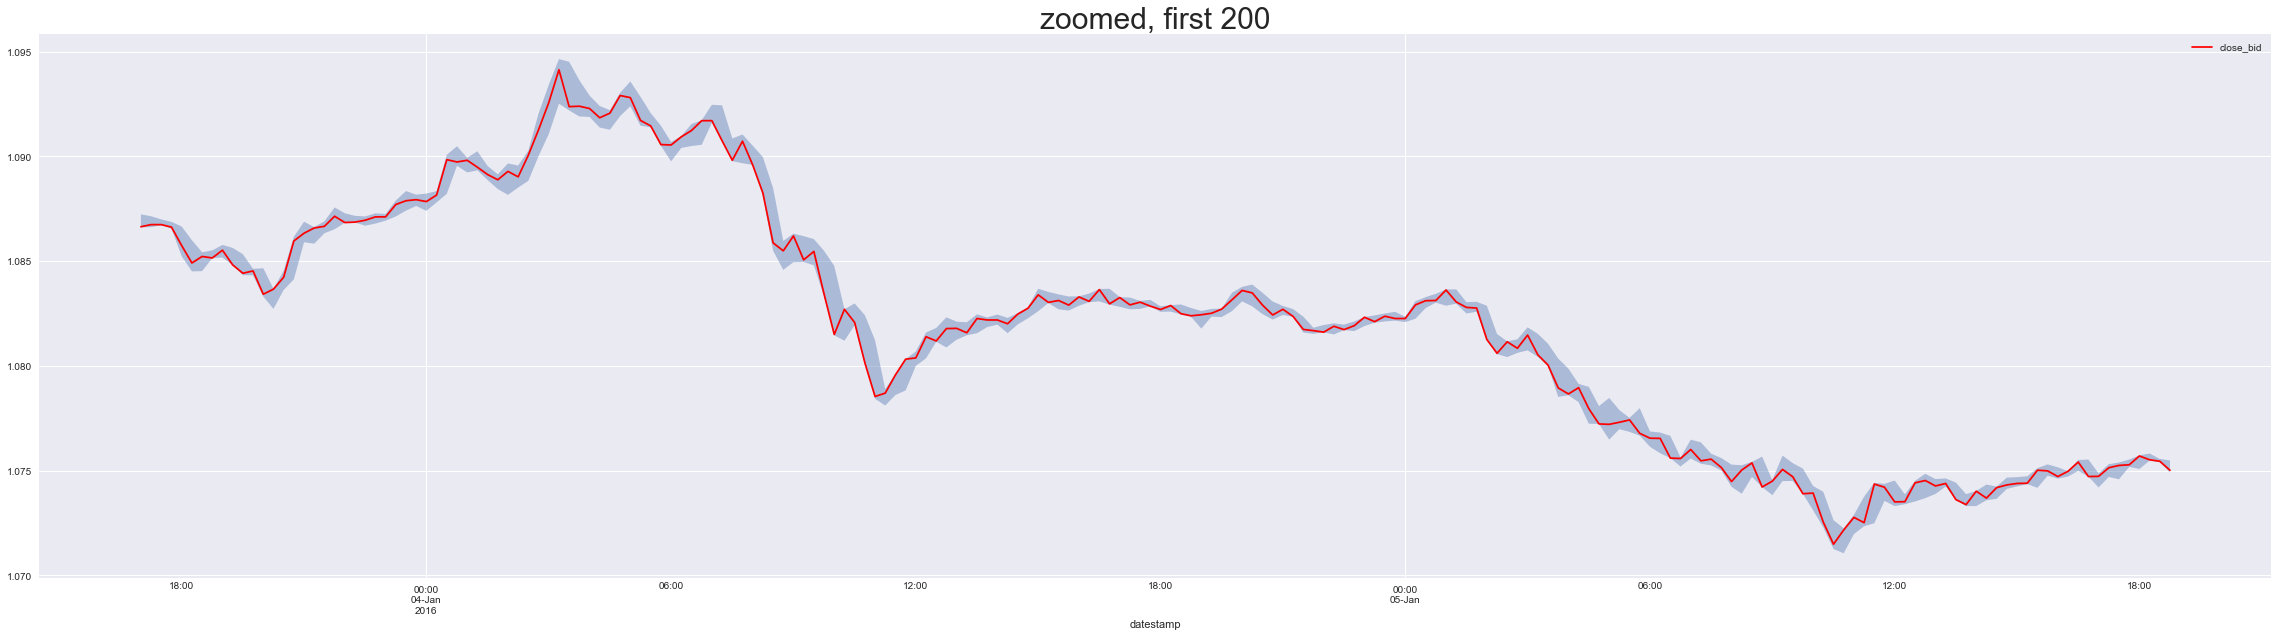

In [8]:
# plot close price, compare to low and high price
ax = df.plot(x=df.index, y='close_bid', c='red', figsize=(40,10))
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low_bid',y2='high_bid', data=df, alpha=0.4)
plt.title("entire history", fontsize=30)
plt.show()

# plot first 200 entries 
p = df[:200].copy()
ax = p.plot(x=p.index, y='close_bid', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low_bid', y2='high_bid', data=p, alpha=0.4)
plt.title('zoomed, first 200', fontsize=30)
plt.show()

- there are periods where the price doesnt move, probably weekends. Maybe dont consider these for training

In [43]:
def pltGraph(xname, yname, irow, icol, df, xval=None, yval=None, title=None, norm_axis=None):
    x_axis_col = xname
    y_axis_col = yname
    if xval is None:
        xval = df[x_axis_col]
    if yval is None:
        yval = df[y_axis_col]
    if title is None:
        title = x_axis_col + " vs " + y_axis_col
    if norm_axis is None:
        norm_axis = "x"
  
    #print("before plot:", (title, irow, icol))
    axarr[irow, icol].scatter(xval.values, yval.values, color="green", lw=0, cmap=pylab.cm.cool, alpha=0.8, s=2)
    axarr[irow, icol].set_xlim(xval.values.min(), xval.values.max())
    axarr[irow, icol].set_ylim(yval.values.min(), yval.values.max())
    axarr[irow, icol].set_xlabel(x_axis_col)
    axarr[irow, icol].set_ylabel(yname)
    axarr[irow, icol].set_title(title)
    axarr[irow, icol].grid(False)
    
    irow,icol=get_next_irow_icol(irow,icol,axarr)
    
    return irow, icol

In [53]:
def get_next_irow_icol(irow, icol, axarr):
    try:
        if (irow+1 > axarr.shape[0]-1) and (icol+1 > axarr.shape[1]-1):

            raise ValueError("need more rows")

        if icol+1 > axarr.shape[1]-1:
            icol = 0
            irow +=1
        else:
            icol +=1
    except:
        pass
        # create new plot
        fig,axarr = plt.subplots(2,2)
        
    return irow, icol

In [84]:
import datetime
datetime.datetime.now().time().strftime("%H%M%S")

'150914'

In [90]:
def get_new_plot_and_plot_prev(title=None):
    
    
    plt.savefig("report graphs/"+title+"_fig.png")
    
    fig, axarr = plt.subplots(2, 2, figsize=(10,10)) #1 row, 2 cols, x, y
    irow, icol = 0,0
    return fig, axarr, irow, icol

c:\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


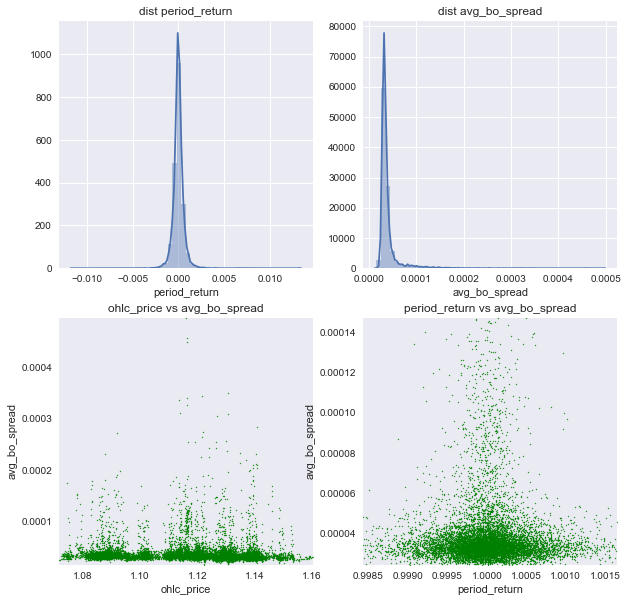

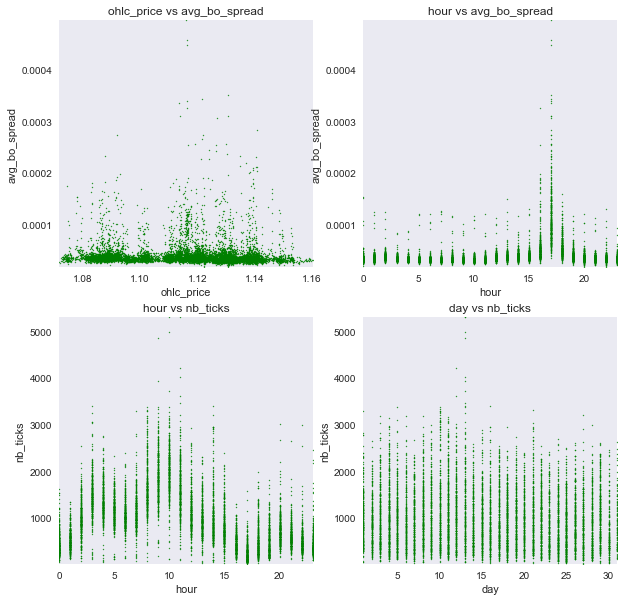

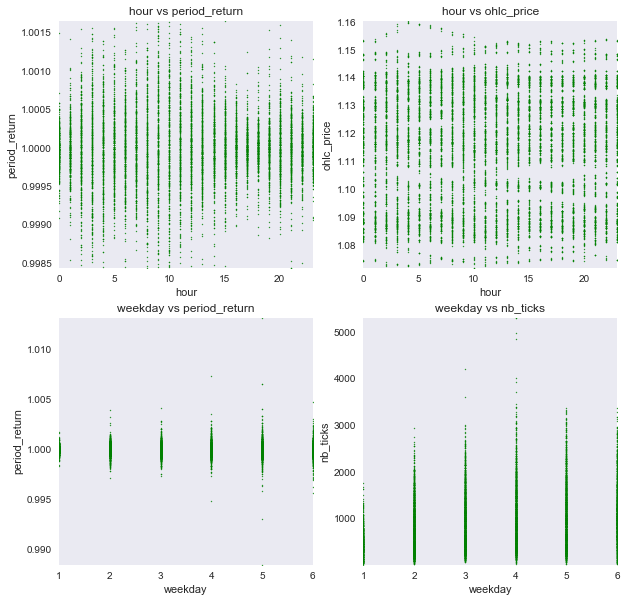

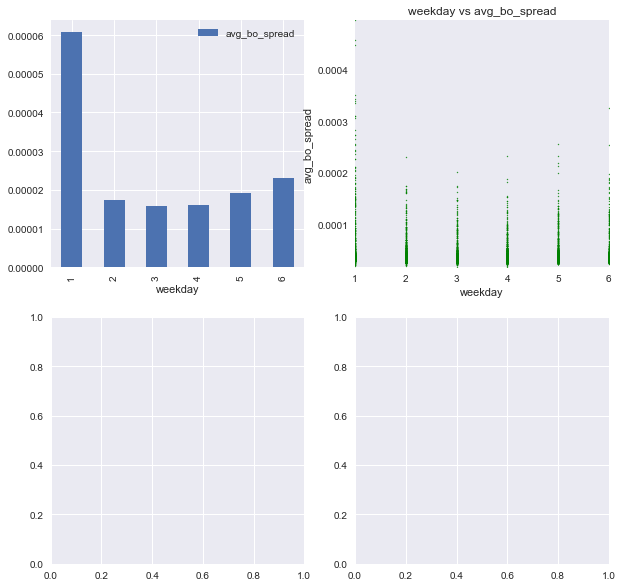

Nb Rows:  10204


In [93]:
# create ohlc prices, analyse distribution, think about feature transformation and de-trending

fig, axarr = plt.subplots(2, 2, figsize=(10,10)) #1 row, 2 cols, x, y
#plt.figure(figsize=(20, 4))
irow, icol = 0,0
#fig.suptitle("frequency distributions")


sns.distplot(df.period_return-1, ax=axarr[irow, icol])
axarr[irow, icol].set_title("dist period_return")
irow,icol=get_next_irow_icol(irow,icol,axarr)

if simname != "bm_kaggle":
    
    sns.distplot(df.avg_bo_spread, ax=axarr[irow, icol])
    axarr[irow, icol].set_title("dist avg_bo_spread")
    irow,icol=get_next_irow_icol(irow,icol,axarr)
    irow,icol = pltGraph("ohlc_price", "avg_bo_spread", irow, icol, df)
    qlow, qhigh = 0.01, 0.99
    df_mask = df.loc[(df.period_return < df.period_return.quantile(qhigh) ) & (df.period_return > df.period_return.quantile(qlow)) & (df.avg_bo_spread < df.avg_bo_spread.quantile(qhigh) ) & (df.avg_bo_spread > df.avg_bo_spread.quantile(qlow)),:]
    #df_mask = df.loc[(df.period_return < df.period_return.quantile(qhigh) ) & (df.period_return > df.period_return.quantile(qlow)) & (df.avg_bo_spread < 0.0001 ) & (df.avg_bo_spread > -0.0001),:]
    irow,icol = pltGraph("period_return", "avg_bo_spread", irow, icol, df_mask)
    
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("exp1")
    
    irow,icol = pltGraph("ohlc_price", "avg_bo_spread", irow, icol, df)
    irow,icol = pltGraph("hour", "avg_bo_spread", irow, icol, df)
    irow,icol = pltGraph("hour", "nb_ticks", irow, icol, df)
    irow,icol = pltGraph("day", "nb_ticks", irow, icol, df)
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("exp2")
    
    df_mask = df.loc[(df.period_return < df.period_return.quantile(qhigh) ) & (df.period_return > df.period_return.quantile(qlow)),:]
    irow,icol = pltGraph("hour", "period_return", irow, icol, df_mask)
    irow,icol = pltGraph("hour", "ohlc_price", irow, icol, df)
    irow,icol = pltGraph("weekday", "period_return", irow, icol, df)
    irow,icol = pltGraph("weekday", "nb_ticks", irow, icol, df)
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("exp3")
    
    res = df.loc[:,["weekday", "avg_bo_spread"]].groupby("weekday").std()
    res.plot(kind="bar", ax=axarr[irow, icol])
    irow,icol=get_next_irow_icol(irow,icol,axarr)
    
    irow,icol = pltGraph("weekday", "avg_bo_spread", irow, icol, df)
    
    #plt.tight_layout()    
    title = "exp4"
    plt.savefig("report graphs/"+title+"_fig.png")
    plt.show()
    

print("Nb Rows: ", df.high_bid.count())

- it seems the hours with the least number of ticks have the highest bo spread. This is expected, as during low activity traders might set spreads wide to avoid surprises.
- period return is between two closing bids, 15 minutes apart. It might be a spurious measure.
- do i have to stick to 15 minute intervals to complete this?
- weekday 1 seems to have higher stdev of avg bo spread

# Add PCA as a feature and show graphs

In [94]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
from sklearn.decomposition import PCA

df_np = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(df_np)

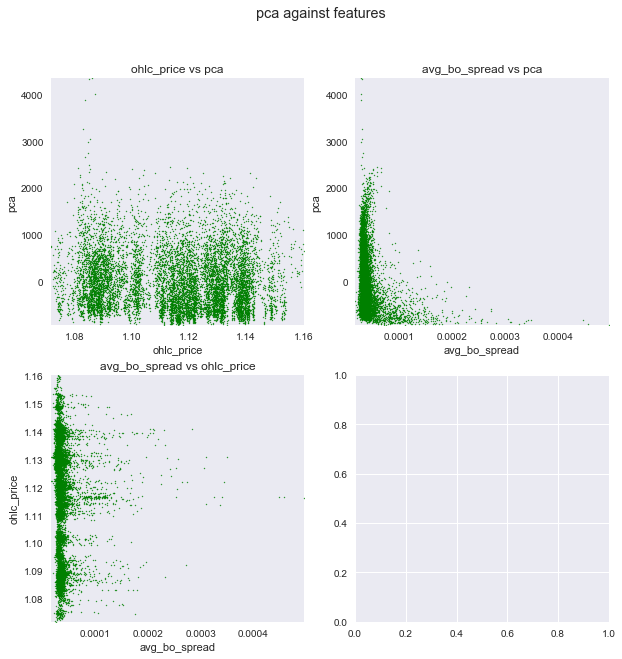

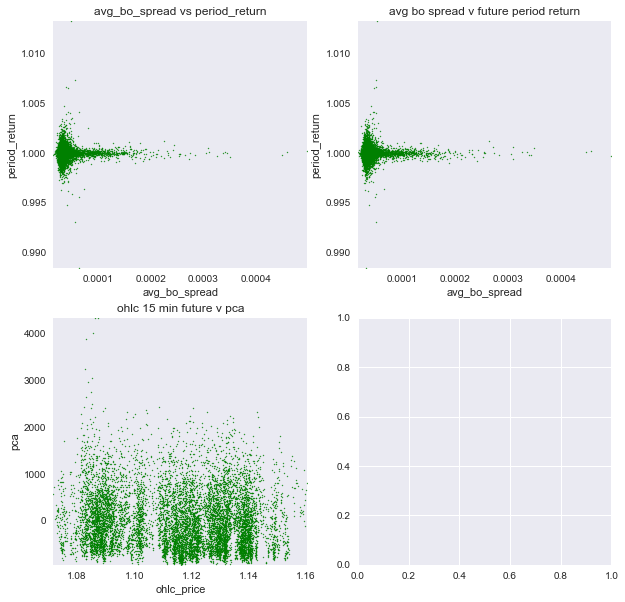

In [95]:

fig, axarr = plt.subplots(2, 2, figsize=(10,10)) #1 row, 2 cols, x, y
irow, icol = 0,0
fig.suptitle("pca against features")

if simname != "bm_kaggle":
    
    irow,icol = pltGraph("ohlc_price", "pca", irow, icol, df)
    irow,icol = pltGraph("avg_bo_spread", "pca", irow, icol, df)
    irow,icol = pltGraph("avg_bo_spread", "ohlc_price", irow, icol, df)
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("pca1")
    
    irow,icol = pltGraph("avg_bo_spread", "period_return", irow, icol, df)
    irow,icol = pltGraph("avg_bo_spread", "period_return", irow, icol, df, yval=df['period_return'].shift(periods=1).fillna(method="bfill"), title="avg bo spread v future period return")
    irow,icol = pltGraph("ohlc_price", "pca", irow, icol, df, xval=df['ohlc_price'].shift(periods=1).fillna(method="bfill"), title="ohlc 15 min future v pca")
       
    title = "pca2"
    plt.savefig("report graphs/"+title+"_fig.png")
    plt.show()


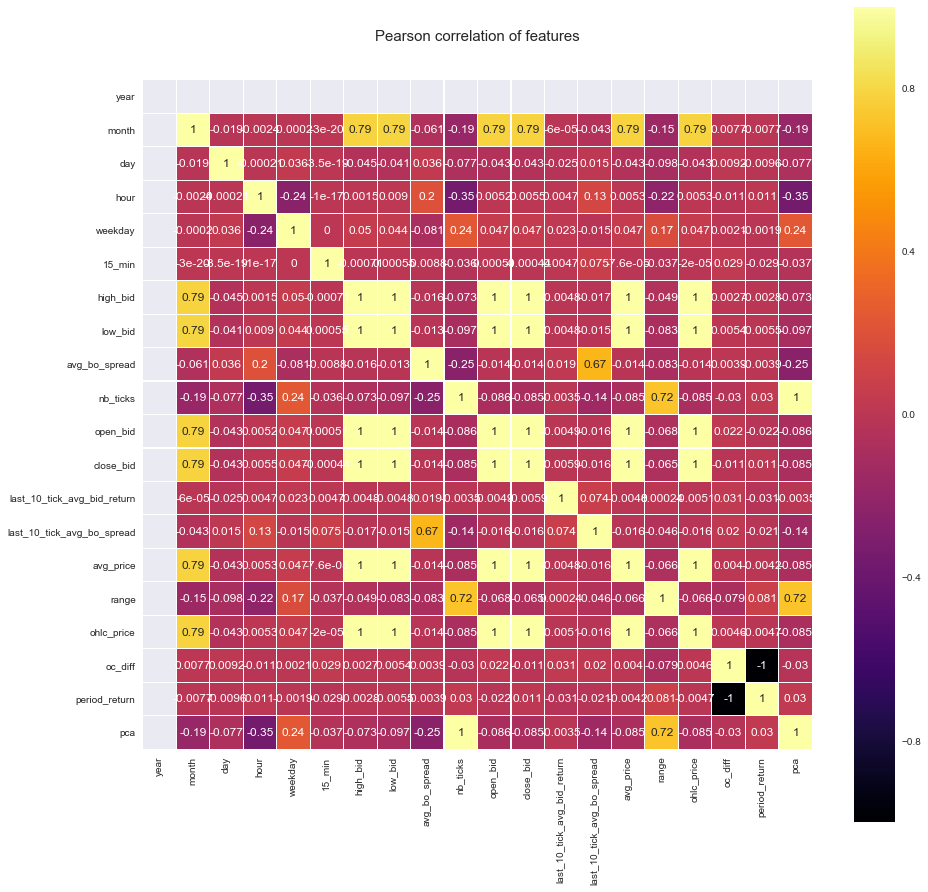

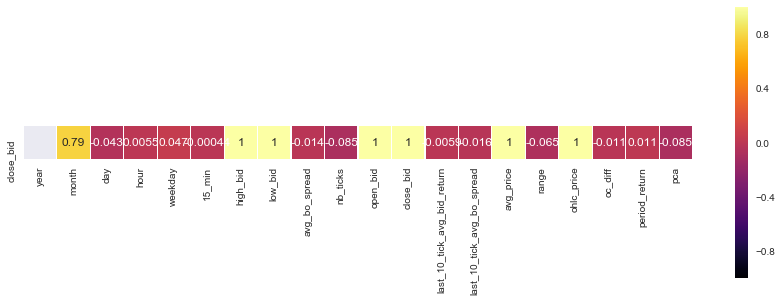

In [97]:
# check feature correlation, to see what correlates with the close price
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
title = "correl1"
plt.savefig("report graphs/"+title+"_fig.png")
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close_bid'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
title = "correl_bid"
plt.savefig("report graphs/"+title+"_fig.png")
plt.show()

# Start running datascience methods

In [98]:
def check_shape(*argv):
    for el in argv:
        print(el.shape)


In [99]:
"""
this creates training examples and actuals for the model
if nb_lookback_rows is above 1, X will have examples each of which is a 20 row dataframe
so the regression model needs to be able to use all those rows to train on
"""

def create_training_set(df, nb_lookback_rows=1):
    
    dataX, dataY = [], [] # for training
    
    # it creates for each row a 20 row lookback dataset
    # this expands the dataset by 20 faculty
    for iRow in range(len(df)-nb_lookback_rows-1): 
        
        df_lookback_rows = df[iRow:(iRow+nb_lookback_rows)] # from example 1 to 21
        dataX.append(df_lookback_rows)
        next_row = df[iRow + nb_lookback_rows] #get example 1+20, so the next point that is to be forecasted
        dataY.append(next_row) 
    
    return np.array(dataX), np.array(dataY) # convert to numpy arrays

# Use Random Forest for feature importance:
Check which feature is most important, based on predicting the next closing price using just one example as training
Do this for each example, and check which features are the best on average
Looking back more than 1 example for each example requires a decision how to use the features. Do recent examples features get more weight?

- scale all features to range 0-1 for faster convergence
- use random forest to find best decision tree to explain closing price

In [100]:
# create random forest regressor - random decision trees, like weak learner, ada boost
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
idx_close_bid = df.columns.tolist().index('close_bid') # predict this, should it be return?
df_np = df.values.astype('float32') # so regressor can use it

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_np) # scale features to between 0 and 1 for faster convergence

# Set look_back to 100 which is 100 ticks
# look back is 1 period, to check which features predict best a 1 period return
look_back_rows = 1 # to work with more than one, use alternative reshape
X, y = create_training_set(df_scaled, nb_lookback_rows=look_back_rows) # look back only 1 row
y = y[:,idx_close_bid]
#TODO:X = np.reshape(X, (X.shape[0], X.shape[2]* look_back_rows)) # to get back rows and columns
X = np.reshape(X, (X.shape[0], X.shape[2])) # to get back rows and columns
# extend extra rows into columns, as all the prices during lookback periodd should be used as features.

In [101]:
check_shape(X)

(10202, 20)


In [102]:
# fit model
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

In [105]:
# find feature with best explanatory power to predict close price
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1] # get indices for importances
#print(indices)

column_list = df.columns.tolist()
#print(column_list)
print("Feature ranking:")
feature_dict = OrderedDict()
for f in range(X.shape[1]-1):
    #print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))
    feature_dict[column_list[indices[f]]] = importances[indices[f]]
print(pd.DataFrame([feature_dict]).T)

Feature ranking:
                                    0
close_bid                    0.926392
ohlc_price                   0.024249
avg_price                    0.022592
high_bid                     0.022400
low_bid                      0.003085
open_bid                     0.000675
last_10_tick_avg_bo_spread   0.000088
last_10_tick_avg_bid_return  0.000085
range                        0.000064
avg_bo_spread                0.000060
pca                          0.000056
nb_ticks                     0.000053
oc_diff                      0.000041
period_return                0.000039
hour                         0.000037
day                          0.000037
weekday                      0.000021
15_min                       0.000017
month                        0.000009


# Try linear regression
- sklearn requires numpy arrays as input
- check how close we can get with linear regression
- resources: http://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
- problem: my features are note independent of each other, eg ohlc price, open bid, close bid etc

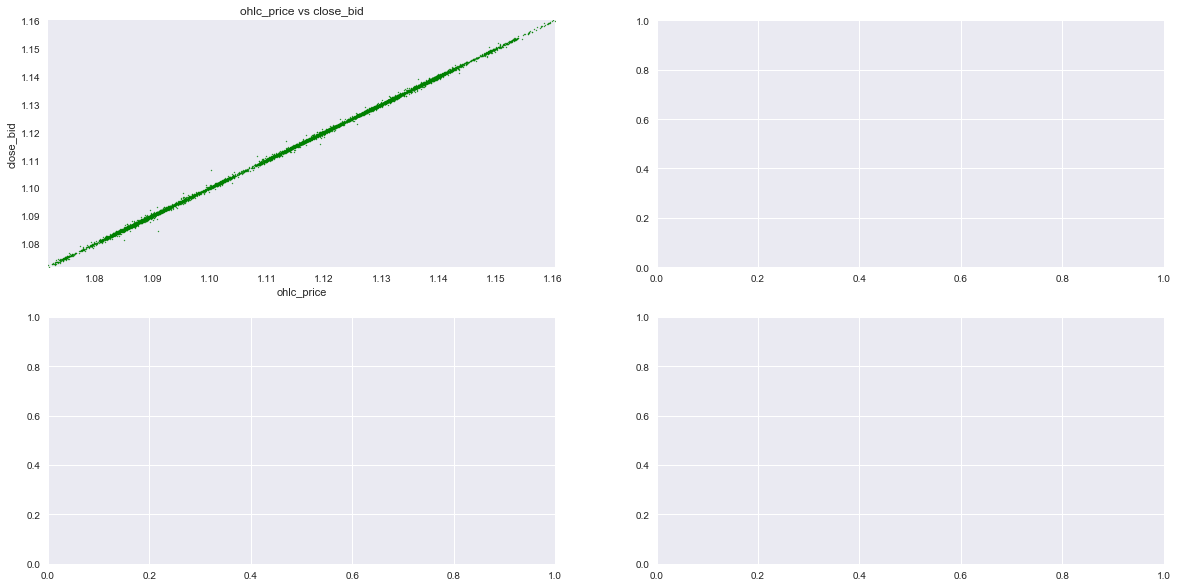

In [106]:
# plot all against close_bid
fig, axarr = plt.subplots(2, 2, figsize=(20,10)) #1 row, 2 cols, x, y
#plt.figure(figsize=(20, 4))
irow, icol = 0,0
icol = pltGraph("ohlc_price", "close_bid", irow, icol, df)
plt.show()


- we may have to address feature correlation

In [107]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# df only
X = df.drop("close_bid", axis=1)
y = df.close_bid.shift().values
cols = X.columns


#convert to numpy first
df_np = df.copy().values.astype('float32')
X, y = create_training_set(df_np, 1)
X = np.reshape(X, (X.shape[0], X.shape[2]))
idx_close_bid = df.columns.tolist().index('close_bid') # find index of columns in dataframe
y = y[:,idx_close_bid] # select column to predict
cols = df.columns # i have all here, because close_bid is included as features


# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)
check_shape(X, y, X_train, X_test, y_train, y_test)

(10202, 20)
(10202,)
(10099, 20)
(103, 20)
(10099,)
(103,)


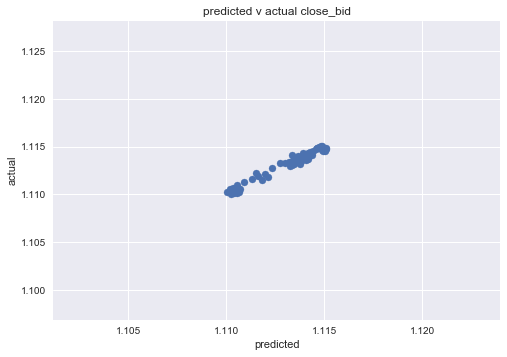

oc_diff                       -0.204211
nb_ticks                      -0.096250
low_bid                       -0.017280
last_10_tick_avg_bo_spread    -0.005564
avg_bo_spread                 -0.003196
avg_price                     -0.003091
last_10_tick_avg_bid_return   -0.002060
weekday                       -0.000060
year                           0.000000
month                          0.000062
15_min                         0.000098
day                            0.000105
hour                           0.000380
high_bid                       0.012807
range                          0.031856
pca                            0.096251
period_return                  0.185722
ohlc_price                     0.199248
open_bid                       0.300989
close_bid                      0.505757
Name: linear regression coefficients, dtype: float64

In [116]:
reg_lasso = linear_model.Lasso(alpha = 0.1) # Lasso takes care of regularisation
reg_linear = linear_model.LinearRegression()

reg_linear.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)


df_coeff = pd.DataFrame(columns=cols
                     , data=[list(reg_linear.coef_), list(reg_lasso.coef_)]
                     , index=["linear regression coefficients", "lasso regression coefficients"])




# predict all examples and compare to actuals
plt.scatter(reg_linear.predict(X_test), y_test)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("predicted v actual close_bid")
plt.show()



df_coeff = df_coeff.sort_values(by='linear regression coefficients', axis=1)
df_coeff.loc["linear regression coefficients",:]




- what mae is acceptible as a result? If i invest based on my prediction, and it goes the other way i lose money. 
- Therefore, check the directional error, not MAE. Compare close with next close. If my prediction - actual next close has the same sign and value of that measure, count as accurate.

## Check regression errors

In [119]:
def check_error_metrics(df, y_train, y_test, X_train_pred, X_test_pred, y_prev):

    #compute direction of next step
#     if len(X_test.shape) >2:
#         y_prev = X_test[:,0,idx_close_bid]
#     else:
#         y_prev = X_test[:,idx_close_bid]
    err_list = []
    
    pred_directions = X_test_pred - y_prev
    act_directions = y_test - y_prev
    pred_returns = X_test_pred / y_prev-1
    act_returns =  y_test / y_prev -1

    

    sign_error = np.sign(pred_directions) != np.sign(act_directions)
    actual_minus_pred = act_directions - pred_directions
    abs_actual_minus_prod = abs(act_directions) - abs(pred_directions)
    return_vals = act_returns - pred_returns

    # how often do you make a negative 1 percent return when a positive return was predicted

    err_list= [
        ["mse train all feature: ", mean_squared_error(y_train, X_train_pred)]
        ,["mse test all feature: ", mean_squared_error(y_test, X_test_pred)]
        ,["mae train all feature: ", mean_absolute_error(y_train, X_train_pred)]
        ,["mae test all feature: ", mean_absolute_error(y_test, X_test_pred)]
        ,["mean avg bo spread: ", df.avg_bo_spread.mean()]
        

        ,["how often sign of price change is same: ", (sign_error==False).sum() / len(sign_error)]

    # if correct sign, how often larger than actual value, smaller than actual value
    # generally good profit
        ,["if same sign, how often is actual better than 0.1 percent in both directions: "
          , (abs(act_directions[~sign_error]) > 0.001).sum() / len(act_directions[~sign_error])]

    # positive surprise
        ,["if same sign, how often is actual better than predicted in both directions: "
          , (abs_actual_minus_prod[~sign_error] > 0).sum() / len(abs_actual_minus_prod[~sign_error])]

    # positive suprise of least 10 bp
        ,["if same sign, how often is actual better than predicted by more than 0.001 USD per EUR in both directions: ", 
          (abs_actual_minus_prod[~sign_error] > 0.001).sum() / len(abs_actual_minus_prod[~sign_error])]





        ,["if not same sign, how often is actual worse than -0.1 percent return from predicted in both directions",
         (abs(return_vals[sign_error]) > 0.001).sum() / len(return_vals[sign_error])]
         
        ,["if not same sign, how often is actual worse than -0.1 percent return in both directions",
         (abs(act_returns[sign_error]) > 0.001).sum() / len(act_returns[sign_error])]
    ]   
    # show histogram of returns if sign error
    plt.hist(act_returns[sign_error], bins=20)
    plt.title("returns if pred and act sign mismatches")
    title = "linreg_error"
    plt.savefig("report graphs/"+title+"_fig.png")
    plt.show()
    
    df_err = pd.DataFrame(err_list)
    
    for el in err_list:
        print(el)
    
    
    return df_err


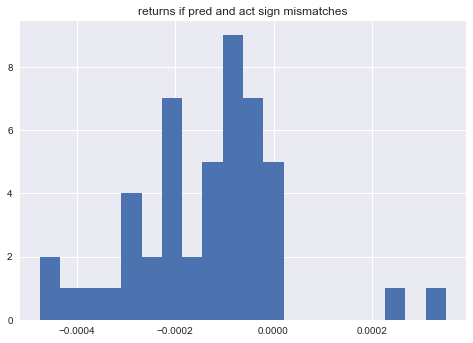

['mse train all feature: ', 4.4530569e-07]
['mse test all feature: ', 6.5385599e-08]
['mae train all feature: ', 0.00042667281]
['mae test all feature: ', 0.0002031199]
['mean avg bo spread: ', 3.9868658581951545e-05]
['how often sign of price change is same: ', 0.53398058252427183]
['if same sign, how often is actual better than 0.1 percent in both directions: ', 0.0]
['if same sign, how often is actual better than predicted in both directions: ', 0.96363636363636362]
['if same sign, how often is actual better than predicted by more than 0.001 USD per EUR in both directions: ', 0.0]
['if not same sign, how often is actual worse than -0.1 percent return from predicted in both directions', 0.0]
['if not same sign, how often is actual worse than -0.1 percent return in both directions', 0.0]


In [120]:
df_err = check_error_metrics(df, y_train, y_test, reg_linear.predict(X_train), reg_linear.predict(X_test), X_test[:,idx_close_bid])

In [36]:
# log results
log=True

if log:
    
    simname= "linear regression"
    sim_desc = "1 row lookback"
    
    dict_err= OrderedDict(zip(df_err[0], df_err[1]))
    
    list_stats=OrderedDict()
    
    list_stats["simname"] = simname
    list_stats["sim_desc"] = sim_desc
    list_stats["MSE"] = dict_err["mse test all feature: "]
    list_stats["MAE"] = dict_err["mae test all feature: "]
    
    differences_described = pd.Series(reg_linear.predict(X_test) - y_test).describe()

    list_stats.update(OrderedDict(differences_described))
    list_stats.update(dict_err)
    
    results = pd.DataFrame([list_stats])
    #results.to_excel("log_results.xlsx")
    if os.path.isfile("log_results.xlsx"):
        log_results = pd.read_excel("log_results.xlsx")
        log_results.loc[len(log_results),:] = list_stats.values()
        log_results.to_excel("log_results.xlsx")
    #log_results

In [37]:
pd.read_excel("log_results.xlsx").T
import matplotlib.pyplot as plt
title = "linreg_error"
plt.imsave("report graphs/"+title+"_fig.png", )
#plt.imsave("Path/To/Save", plotname)

,0,1,2,3,4,5
simname,500_epochs,500_epoch_lookback_40,linear regression,linear regression,500_epochs_40_lookback_pca_unshuffled,linear regression
sim_desc,\nkaggle params but with 500 epochs to account...,"500 iterations, lookback 40",1 row lookback,1 row lookback,added directional errors checking and pca as f...,1 row lookback
MSE,1.59188e-07,1.97246e-07,6.79626e-07,6.55241e-08,4.82937e-07,6.52409e-08
MAE,0.000285781,0.000340846,0.000536307,0.000202905,0.000594482,0.000202278
count,102,102,103,103,102,103
mean,-9.29131e-07,-3.83515e-05,-5.08408e-05,-2.90581e-05,0.000506372,-2.31451e-05
std,0.000400953,0.00044465,0.000826849,0.000255566,0.000478296,0.000255616
min,-0.00135148,-0.00127888,-0.00317997,-0.000772953,-0.00072515,-0.000772119
25%,-0.000158489,-0.000304043,-0.000402606,-0.000200629,0.000192821,-0.000199616
50%,6.07371e-05,-5.84126e-06,-3.07747e-05,-2.43187e-05,0.000540495,-1.14441e-05


## Plot residuals

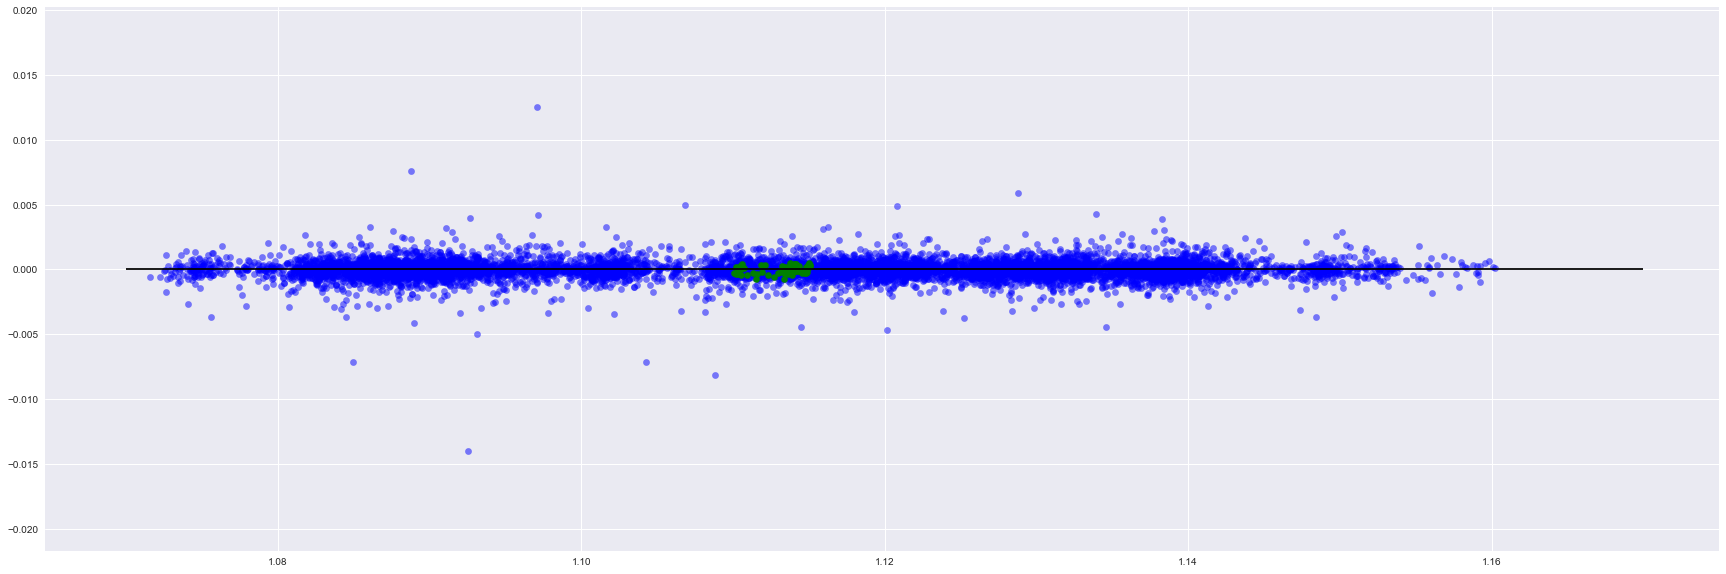

In [38]:
plt.figure(figsize=(30,10))
plt.scatter(reg_linear.predict(X_train), reg_linear.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg_linear.predict(X_test), reg_linear.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y=0, xmin=1.07, xmax = 1.17)
plt.show()

In [39]:
print("pred: %f, actual: %f" % (reg_linear.predict(X_test[0,:].reshape(1,-1)), y_test[0]))

pred: 1.110524, actual: 1.110180


## Try ridge regression, to be more robust to correlation in features

C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.576732214380598e-11 / 5.960464477539063e-08
  RuntimeWarning)


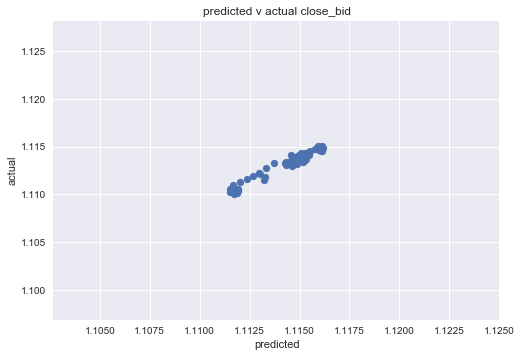

mse train all feature:  9.51813e-07
mse test all feature:  1.49011e-06


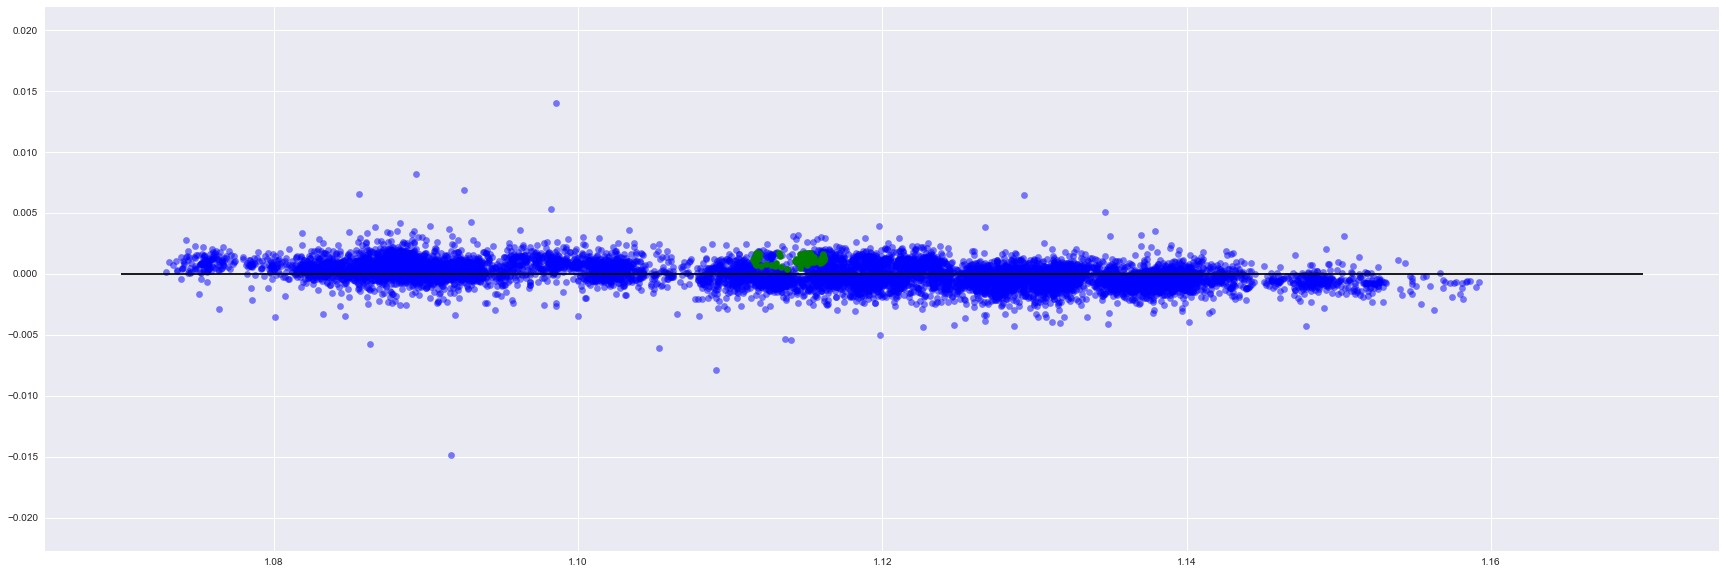

In [40]:
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train) 
reg.coef_


df_coeff = pd.DataFrame(columns=cols
                     , data=[list(reg.coef_)]
                     , index=["ridge regression coefficients"])



# predict all examples and compare to actuals
plt.scatter(reg.predict(X_test), y_test)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("predicted v actual close_bid")
plt.show()


df_coeff.sort_values(by='ridge regression coefficients', axis=1)

print("mse train all feature: ", np.mean((reg.predict(X_train) - y_train) ** 2))
print("mse test all feature: ", np.mean((reg.predict(X_test) - y_test) ** 2))

plt.figure(figsize=(30,10))
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y=0, xmin=1.07, xmax = 1.17)
plt.show()

# Run LSTM Model to predict close bid in next 15 min
- scale features to range 0-1 to speed up convergence
- set a larger lookback windows, so LSTM has something to work with and can take a decision which part of history to prioritise
- todo: make it do error on the sign- for that need to get the sign between next and X[bid]
- 1% test size, 10% of 99% validation size
- try to also predict direction. y_pred - X_test close versus y_act - X_test close

## Predict sign only

In [41]:
if runLSTMBinary:
    # Scale and create datasets
    idx_close_bid = df.columns.tolist().index('close_bid')
    df_np = df.values.astype('float32')

    # Scale the examples
    df_scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = df_scaler.fit_transform(df_np)

    # Scale the actuals columns, but not the real values
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    t_y = df['close_bid'].values.astype('float32')
    t_y = np.reshape(t_y, (-1, 1))
    y_scaler = y_scaler.fit(t_y) # create a fitted y scaler

    # Set look_back to 20 which is 5 hours (15min*20)
    X, y_orig = create_training_set(df_scaled, nb_lookback_rows=40)
    #y_return_sign = np.sign(y[:,idx_close_bid] - X[:,0,idx_close_bid]) # these are the actuals
    y_return_sign = y_orig[:,idx_close_bid] - X[:,0,idx_close_bid] # these are the actuals
    y = np.sign(y_return_sign) # an array of -1, 1 and 0

    y = pd.get_dummies(y).values.astype('float32')



    # need to create a binarised vector, one positive class, one negative class
    #y_pred_return_sign = # comes from model

## Predict exact price value

In [42]:
if not runLSTMBinary:
    # Scale and create datasets
    idx_close_bid = df.columns.tolist().index('close_bid')
    #idx_high = df.columns.tolist().index('high_bid')
    #idx_low = df.columns.tolist().index('low_bid')
    df_np = df.values.astype('float32')

    # Scale the examples
    df_scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = df_scaler.fit_transform(df_np)

    # Scale the actuals columns, but not the real values
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    t_y = df['close_bid'].values.astype('float32')
    t_y = np.reshape(t_y, (-1, 1))
    y_scaler = y_scaler.fit(t_y) # create a fitted y scaler

    # Set look_back to 20 which is 5 hours (15min*20)
    X, y = create_training_set(df_scaled, nb_lookback_rows=40)
    y = y[:,idx_close_bid]

In [43]:
# Set training data size
# We have a large enough dataset. So divid into 99% training and val (10% of those 99%) / 1% test set
import sklearn
sklearn.__version__
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, shuffle=False)       
check_shape(X, y, X_train, X_test, y_train, y_test)

(10163, 40, 20)
(10163,)
(10061, 40, 20)
(102, 40, 20)
(10061,)
(102,)


In [44]:
from keras.backend import categorical_crossentropy
# ensure there is a 1st derivative! else get none error
# it will check in which direction this error goesn down and walk there
# maybe it has issue because sign is not continuous...
# just use categorical crossentropy, it does exactly what i need much better
def ret_direction_error(y_true, y_pred):
    
    # this guy puts everything into numpy before working on it https://stackoverflow.com/questions/46411573/keras-custom-loss-function-not-working
     
    out = categorical_crossentropy(y_true, y_pred)
    
    return out
    
    # y_true is y_train, y_pred is what the model gives me
    # so should set y_true to the return sign? and stop training on absolute value, but make sure sign is right

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense
import keras.backend as K
import tensorflow as tf

# create a small LSTM network
# shoudl first input number match nb of lookback rows?
model = Sequential()
model.add(LSTM(40, input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) # does not take into account nb examples
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10, return_sequences=True)) # a second layer of 10 really helps get the loos to 7 by 10th epoch
model.add(Dropout(0.2))
model.add(LSTM(5, return_sequences=False))
model.add(Dense(5, kernel_initializer='uniform', activation='relu'))

# for price prediction
if not runLSTMBinary:
    model.add(Dense(1, kernel_initializer='uniform', activation='relu')) # this compresses everything to one output in the final layer
    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae', 'mse', 'accuracy'])
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse', 'accuracy'])
    
    
# for direction prediction
if runLSTMBinary:
    # need a softmax output for category predictions
    model.add(Dense(3, activation="softmax"))   

    # loss: optimises this - https://keras.io/losses/
    # loss will show up in the history under 'loss'
    model.compile(loss=ret_direction_error, optimizer='adam', metrics=['mae', 'mse', ret_direction_error, 'accuracy'])
    
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 40, 40)            9760      
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 20)            4880      
_________________________________________________________________
lstm_8 (LSTM)                (None, 40, 10)            1240      
_________________________________________________________________
lstm_9 (LSTM)                (None, 40, 10)            840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 10)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
__________

In [75]:
simname = "500_epochs_40_lookback_pca_unshuffled_binary"
sim_desc = "added directional errors checking and pca as feature with unshuffled data"


In [76]:

# Save the best weight during training. Cant handel custom functions for errors
from keras.callbacks import ModelCheckpoint
epoch = 500

# write custom errors as string, they seem to refer to the key in err.history dict
if not runLSTMBinary:
    #checkpoint = ModelCheckpoint(simname + ".weights.best.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    checkpoint = ModelCheckpoint(simname + ".weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

if runLSTMBinary:
    checkpoint = ModelCheckpoint(simname + ".weights.best.hdf5", monitor='val_ret_direction_error', verbose=1, save_best_only=True, mode='min')

# Fit
"""
it seems batch size controls convergence speed a lot! Batch size tells how many examples are propagated through the network.
Weights are adjusted based on results with these examples. This is useful if the full dataset takes too much memory
It also speeds up training, as you will converge quicker (dont have to wait for a full iteration of each example to adjust weights).

With more features to train on, convergence seems slower. To get to the same level, i take more epochs.
"""
callbacks_list = [checkpoint]
%time err = model.fit(X_train, y_train, epochs=epoch, batch_size=100, verbose=0, callbacks=callbacks_list, validation_split=0.1)

Epoch 00000: val_mean_squared_error improved from inf to 0.06875, saving model to 500_epochs_40_lookback_pca_unshuffled_binary.weights.best.hdf5
Epoch 00001: val_mean_squared_error improved from 0.06875 to 0.01363, saving model to 500_epochs_40_lookback_pca_unshuffled_binary.weights.best.hdf5
Epoch 00002: val_mean_squared_error improved from 0.01363 to 0.01334, saving model to 500_epochs_40_lookback_pca_unshuffled_binary.weights.best.hdf5
Epoch 00003: val_mean_squared_error improved from 0.01334 to 0.01233, saving model to 500_epochs_40_lookback_pca_unshuffled_binary.weights.best.hdf5
Epoch 00004: val_mean_squared_error did not improve
Epoch 00005: val_mean_squared_error did not improve
Epoch 00006: val_mean_squared_error improved from 0.01233 to 0.01223, saving model to 500_epochs_40_lookback_pca_unshuffled_binary.weights.best.hdf5
Epoch 00007: val_mean_squared_error improved from 0.01223 to 0.00177, saving model to 500_epochs_40_lookback_pca_unshuffled_binary.weights.best.hdf5
Epoch 

Epoch 00115: val_mean_squared_error did not improve
Epoch 00116: val_mean_squared_error did not improve
Epoch 00117: val_mean_squared_error did not improve
Epoch 00118: val_mean_squared_error did not improve
Epoch 00119: val_mean_squared_error did not improve
Epoch 00120: val_mean_squared_error did not improve
Epoch 00121: val_mean_squared_error did not improve
Epoch 00122: val_mean_squared_error did not improve
Epoch 00123: val_mean_squared_error did not improve
Epoch 00124: val_mean_squared_error did not improve
Epoch 00125: val_mean_squared_error did not improve
Epoch 00126: val_mean_squared_error did not improve
Epoch 00127: val_mean_squared_error did not improve
Epoch 00128: val_mean_squared_error did not improve
Epoch 00129: val_mean_squared_error did not improve
Epoch 00130: val_mean_squared_error did not improve
Epoch 00131: val_mean_squared_error did not improve
Epoch 00132: val_mean_squared_error did not improve
Epoch 00133: val_mean_squared_error did not improve
Epoch 00134:

Epoch 00269: val_mean_squared_error did not improve
Epoch 00270: val_mean_squared_error did not improve
Epoch 00271: val_mean_squared_error did not improve
Epoch 00272: val_mean_squared_error did not improve
Epoch 00273: val_mean_squared_error did not improve
Epoch 00274: val_mean_squared_error did not improve
Epoch 00275: val_mean_squared_error did not improve
Epoch 00276: val_mean_squared_error did not improve
Epoch 00277: val_mean_squared_error did not improve
Epoch 00278: val_mean_squared_error did not improve
Epoch 00279: val_mean_squared_error did not improve
Epoch 00280: val_mean_squared_error did not improve
Epoch 00281: val_mean_squared_error did not improve
Epoch 00282: val_mean_squared_error did not improve
Epoch 00283: val_mean_squared_error did not improve
Epoch 00284: val_mean_squared_error did not improve
Epoch 00285: val_mean_squared_error did not improve
Epoch 00286: val_mean_squared_error did not improve
Epoch 00287: val_mean_squared_error did not improve
Epoch 00288:

KeyboardInterrupt: 

## Check testing errors
- it converges to a low number very fast - how can i get more detail
- but if i split using cross val split with random state, it takes ages to converge. Maybe i should only allow training on the past, as the model will always be used to predict the future. So training on random parts of the timeseries to predict other random parts might destroy historical trends that influence the future, and can be learned by the model.
- train it on directional error for more useful results. Need y_train - X_train[:,idx_close_bid] as feature and evaluate against y_true - X_train[:,idx_close_bid]
- it seems the model always predicts negative, so column zero
- its easier to optimise over mse than mae, because values bigger and would decline more, so better gradients.

Issues:
- cannot checkpoint custom error functions
- cannot write custom error functions
- cannot debug custom error functions

In [79]:

#pd.DataFrame(model.predict(X_train))
print(pd.DataFrame(y_train).sum()) # classes are quite balanced
pd.DataFrame(err.history)

0    4945.484375
dtype: float32


,acc,loss,mean_absolute_error,mean_squared_error,val_acc,val_loss,val_mean_absolute_error,val_mean_squared_error
0,0.000221,0.108767,0.108767,0.018983,0.0,0.121210,0.121210,0.019710
1,0.000221,0.075678,0.075678,0.009418,0.0,0.064085,0.064085,0.005192
2,0.000221,0.046499,0.046499,0.003853,0.0,0.075462,0.075462,0.006855
3,0.000221,0.039816,0.039816,0.002767,0.0,0.023818,0.023818,0.000790
4,0.000221,0.039482,0.039482,0.002768,0.0,0.030328,0.030328,0.001532
5,0.000221,0.033949,0.033949,0.002212,0.0,0.031965,0.031965,0.001608
6,0.000221,0.032927,0.032927,0.002076,0.0,0.020286,0.020286,0.000780
7,0.000221,0.032203,0.032203,0.001955,0.0,0.021150,0.021150,0.000868
8,0.000221,0.030479,0.030479,0.001798,0.0,0.019870,0.019870,0.000778
9,0.000221,0.030525,0.030525,0.001765,0.0,0.019043,0.019043,0.000673


In [78]:
print("smallest validation MAE: ", min(err.history['val_mean_absolute_error']))
print("smallest validation MSE: ", min(err.history['val_mean_squared_error']))



smallest validation MAE:  0.0190429590761
smallest validation MSE:  0.000619442572553


In [ ]:
for error_metric in list(err.history.keys()):
    if 'val' not in error_metric:
        plt.figure(figsize=(40,10))
        plt.plot(err.history[error_metric])
        plt.plot(err.history['val_' + error_metric])
        plt.title(error_metric, fontsize=30)
        plt.ylabel(error_metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left', fontsize=30)
        plt.show()

## Rerun LSTM with decaying learning rate:

As seen from the above, the model seems to have converged nicely, but the mean absolute error on the development data remains at ~0.003X which means the model is unusable in practice. Ideally, we want to get ~0.0005. Let's go back to the best weight, and decay the learning rate while retraining the model

We need this to get inside the average bid offer spread for EUR/USD, so 1.10115 - 1.10110. But lets not forget the data is scaled. Maybe it looks better when we unscale it.

In [ ]:
# tune model by starting from best weights and rerunning with decaying learning rate
# Load the weight that worked the best
model.load_weights(simname+".weights.best.hdf5")
#epoch=60

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler) # do sth to learning rate

callbacks_list = [checkpoint, lr_decay] # checkin with these once in a while
err_decay_lr = model.fit(X_train, y_train, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

## Check testing errors after decaying learning rate
 - here error chart resolution is better, as we start from the trained model

In [77]:
print("smallest validation MAE: ", min(err.history['val_mean_absolute_error']))
print("smallest validation MSE: ", min(err.history['val_mean_squared_error']))
print("decay lr: smallest validation MAE: ", min(err_decay_lr.history['val_mean_absolute_error']))
print("decay lr: smallest validation MSE: ", min(err_decay_lr.history['val_mean_squared_error']))


smallest validation MAE:  0.0190429590761
smallest validation MSE:  0.000619442572553
decay lr: smallest validation MAE:  0.0123163131533
decay lr: smallest validation MSE:  0.000265824883329


In [ ]:
for error_metric in list(err_decay_lr.history.keys()):
    if 'val' not in error_metric:
        plt.figure(figsize=(40,10))
        plt.plot(err_decay_lr.history[error_metric]) # this is for train
        plt.plot(err_decay_lr.history['val_' + error_metric]) # this is for test
        plt.title(error_metric, fontsize=30)
        plt.ylabel(error_metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left', fontsize=30)
        plt.show()


The variance should have improved slightly. However, unless the mean absolute error is small enough, the model is not usable in practice. This is mainly due to only using the sample data for training and limiting epoch to a few hundreds.


## Check scaled predictions


In [ ]:
#simname = "500_epochs_40_lookback"
model.load_weights(simname+".weights.best.hdf5")

In [ ]:
if not runLSTMBinary:
    # Benchmark
    model.load_weights(simname+".weights.best.hdf5")

    X_test_pred = model.predict(X_test) # predict on testset

    predictions = pd.DataFrame()
    predictions['predicted'] = pd.Series(np.reshape(X_test_pred, (X_test_pred.shape[0])))
    predictions['actual'] = y_test
    predictions = predictions.astype(float)


    fig, axarr = plt.subplots(1, 2, figsize=(15,5)) #1 row, 2 cols, x, y
    i_row, icol = 0,0
    fig.suptitle("predictions on test set", fontsize=20)
    predictions.plot(ax=axarr[icol])
    axarr[icol].set_title("Predicted close vs actual over time")

    icol +=1
    predictions['diff'] = predictions['actual'] - predictions['predicted']
    sns.distplot(predictions['diff'], ax=axarr[icol]);
    axarr[icol].set_title('Distribution of differences: actual minus predicted')
    plt.show()

    print("MSE scaled : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
    print("MAE scaled: ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
    #predictions['diff'].describe()

## Check unscaled predictions


In [ ]:
#unscale predictions and actuals
X_test_pred = model.predict(X_test)
X_test_pred_unscaled = y_scaler.inverse_transform(X_test_pred)
X_test_pred_unscaled = np.reshape(X_test_pred_unscaled, (X_test_pred_unscaled.shape[0]))

actual = y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
actual = np.reshape(actual, (actual.shape[0]))

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(X_test_pred_unscaled)
predictions['close_bid'] = pd.Series(actual)


# get low and high bid from untransformed dataframe
p = df[-X_test_pred_unscaled.shape[0]:].copy()
predictions.index = p.index # get the date index  from the dataframe
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low_bid', 'high_bid']], right_index=True, left_index=True)



In [ ]:
if not runLSTMBinary:
    fig, axarr = plt.subplots(1, 4, figsize=(5,10)) #1 row, 2 cols, x, y
    irow, icol = 0,0

    predictions.plot(x=predictions.index, y='close_bid', c='red', figsize=(40,10), ax=axarr[icol])
    predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40,10), ax=axarr[icol])
    index = [str(item) for item in predictions.index]
    #plt.fill_between(x=predictions.index, y1='low_bid', y2='high_bid', data=predictions, alpha=0.4)
    axarr[icol].set_title('Prediction vs Actual (low and high as blue region)')

    icol += 1
    predictions['diff'] = predictions['predicted'] - predictions['close_bid']
    sns.distplot(predictions['diff'], ax=axarr[icol]);
    axarr[icol].set_title('Distribution of differences between actual and prediction ')
    #plt.savefig(simname+"__histogram__actual_minus_pred.jpg")

    icol += 1
    sns.kdeplot(predictions["diff"], predictions["predicted"], kind="kde", space=0, ax=axarr[icol])
    #sns.jointplot(predictions["diff"], predictions["predicted"], kind="kde", space=0, ax=axarr[icol]) # must be by itself
    axarr[icol].set_title('Distribution of error and price')
    #plt.savefig(simname+"__contour__error_v_price.jpg")


    icol +=1
    predictions['correct'] = (predictions['predicted'] <= predictions['high_bid']) & (predictions['predicted'] >= predictions['low_bid'])
    predictions.correct.value_counts().plot(kind="bar", ax=axarr[icol])
    axarr[icol].set_title("True (in high low range), False prediction counts")

    plt.show()

    print("MSE unscaled : ", mean_squared_error(predictions['predicted'].values, predictions['close_bid'].values))
    print("MAE unscaled: ", mean_absolute_error(predictions['predicted'].values, predictions['close_bid'].values))
    #predictions['diff'].describe()

## check binary predictions and confusion matrix


In [ ]:
if runLSTMBinary:
    from sklearn.metrics import confusion_matrix

    #check_shape(y_test, model.predict(X_test))

    y_pred_class = np.argmax(model.predict(X_test), axis=1)  # find position of largest argument

    y_test_class = np.argmax(y_test, axis=1)

    test_acc = 100 * np.sum(y_pred_class==y_test_class) / len(y_test)

    print("acc ", test_acc )

    confusion_matrix(y_pred_class, y_test_class)

In [ ]:
if not runLSTMBinary:
    df_unscaled = df_scaler.inverse_transform(df_scaled)

    X_test_unscaled = df_scaler.inverse_transform(np.reshape(X_test[:,0,:], (X_test.shape[0], X_test.shape[2])))
    y_prev = X_test_unscaled[:,idx_close_bid]

    y_train_unscaled =  y_scaler.inverse_transform(np.reshape(y_train, (y_train.shape[0], 1)))
    y_train_unscaled = np.reshape(y_train_unscaled, (y_train_unscaled.shape[0]))

    y_test_unscaled =  y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
    y_test_unscaled = np.reshape(y_test_unscaled, (y_test_unscaled.shape[0]))


    X_train_pred = model.predict(X_train)
    X_train_pred_unscaled = y_scaler.inverse_transform(X_train_pred)
    X_train_pred_unscaled = np.reshape(X_train_pred_unscaled, (X_train_pred_unscaled.shape[0]))

    #check_shape(df,y_train_unscaled, y_test_unscaled, X_train_pred_unscaled, X_test_pred_unscaled, y_prev)

    df_err = check_error_metrics(df
                        , y_train_unscaled, y_test_unscaled
                        , X_train_pred_unscaled, X_test_pred_unscaled
                        , y_prev)
    #idx_close_bid
    #X_test[:,0,idx_close_bid].shape

Sim results:
- runing at 500 epochs converges a bit better. seems extra features need more time.

# Check logs and compare to previous simulations

In [ ]:
log = True
initval=False
#sim_desc = "500 iterations, lookback 40"
#simname = "500_epoch_lookback_40"

In [ ]:
from collections import OrderedDict
list_stats=OrderedDict()

if log:
    #simname= "linear regression"
    #sim_desc = "1 row lookback"
    
    dict_err= OrderedDict(zip(df_err[0], df_err[1]))
    
    list_stats=OrderedDict()
    
    list_stats["simname"] = simname
    list_stats["sim_desc"] = sim_desc
    list_stats["MSE"] = dict_err["mse test all feature: "]
    list_stats["MAE"] = dict_err["mae test all feature: "]
    
    differences_described = predictions["diff"].describe()

    list_stats.update(OrderedDict(differences_described))
    list_stats.update(dict_err)
    
    results = pd.DataFrame([list_stats])
    #results.to_excel("log_results.xlsx")
    if os.path.isfile("log_results.xlsx"):
        log_results = pd.read_excel("log_results.xlsx")
        log_results.loc[len(log_results),:] = list_stats.values()
        log_results.to_excel("log_results.xlsx")
    #log_results


In [ ]:
pd.read_excel("log_results.xlsx").T